# __DataCrohn__

__Autores__: Aline Silva dos Santos, Jônatas Rafael de Oliveira Melo e Letícia Nunes de Souza Andrade.

## Introdução

A Doença de Crohn é uma condição inflamatória crônica do trato gastrointestinal, cuja etiologia envolve fatores genéticos, imunológicos e ambientais. Identificar padrões de expressão gênica associados à doença pode contribuir tanto para o diagnóstico precoce quanto para a estratificação de risco de pacientes, oferecendo compreensões valiosas para pesquisas biomédicas e possíveis intervenções terapêuticas.

Foram adotados seis modelos de aprendizado supervisionado para a tarefa de classificação: Dummy (baseline), Naive Bayes, Regressão Logística, SVM, Random Forest e XGBoost. Essa seleção permitiu que fossem avaliadas a robustez preditiva, a interpretabilidade e a complexidade de aprendizado, aspectos essenciais em contextos clínicos.

A avaliação do desempenho dos modelos é realizada com base em métricas clássicas de classificação, destacando-se a AUC-ROC, que reflete a capacidade do modelo em distinguir entre as classes positivas e negativas, e o desvio padrão, que indica a estabilidade da previsão entre diferentes execuções. Além disso, estratégias de validação cruzada e otimização de hiperparâmetros via Optuna foram empregadas para assegurar a robustez e a generalização dos resultados.

Este estudo visa, portanto, não apenas apresentar um modelo preditivo de alta performance, mas também fornecer percepções interpretáveis sobre padrões de expressão gênica relacionados à Doença de Crohn, promovendo um entendimento mais aprofundado da biologia da doença e contribuindo para futuras investigações clínicas.


## Metodologia

### 0. Importando bibliotecas

In [33]:
# Tratamento de dados
import pandas as pd
import numpy as np
from collections import Counter

# Aprendizado de máquina
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, make_scorer
import joblib

# Otimização de hiperparâmetros
import optuna
import optuna.visualization as oviz
from optuna.samplers import TPESampler

# Visualização gráfica
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go

### 1.Tratamento de dados

Este projeto foca na construção de um modelo preditivo supervisionado utilizando o conjunto de dados E-GEOD-101794, proveniente do repositório GEO. O objetivo central é induzir um modelo de classificação binária capaz de distinguir amostras de pacientes com Doença de Crohn ($y=1$) de controles não inflamatórios ($y=0$). As features ($X$) para esta tarefa são compostas pela expressão de 65.217 genes, complementadas por metadados clínicos cruciais, como idade e sexo.

Nesta etapa será realizada a preparação dos dados, passo crucial capaz de transformar os dados brutos e incompatíveis em um formato estruturado e limpo que os algoritmos de Aprendizado de Máquina exigem.

#### 1.1 Carregamento e Inspeção dos Dados:

Para garantir que todos os dados estão acessíveis.

In [34]:
dados_1 = "E-GEOD-101794-raw-counts.tsv"
dados_2 = "E-GEOD-101794-experiment-design.tsv"
dados_3 = "E-GEOD-101794-analytics.tsv"

# Carregar os DataFrames
df1 = pd.read_csv(dados_1, sep="\t")
df2 = pd.read_csv(dados_2, sep="\t")
df3 = pd.read_csv(dados_3, sep="\t")

# Inspeção dos Dados

# Contagens
print(f"\n[df1] Dimensões: {df1.shape}")
print("Primeiras linhas do df1:")
print(df1.head())

# Metadados
print(f"\n[df2] Dimensões: {df2.shape}")
print("Primeiras linhas do df2:")
print(df2[['Run', 'Sample Characteristic[disease]', 'Sample Characteristic[age at diagnosis]']].head())

# Resultados Estatísticos
print(f"\n[df3] Dimensões: {df3.shape}")
print("Primeiras linhas e colunas relevantes do df3:")
print(df3.iloc[:, :6].head(3))

# Verificação do número de amostras (Instâncias)
num_amostras_df1 = df1.shape[1] - 2  # Subtrai 'Gene ID' e 'Gene Name'
num_amostras_df2 = df2.shape[0]

print()
print(f"Amostras em df1: {num_amostras_df1}")
print(f"Amostras em df2: {num_amostras_df2}")

if num_amostras_df1 == num_amostras_df2:
    print("\nAs dimensões de amostra parecem consistentes para o merge.")
else:
    print("\nALERTA: O número de amostras não coincide. Uma verificação de quais amostras estão faltando será necessária no merge.")

# Armazenando o número de genes (features brutas)
num_genes = df1.shape[0]
print(f"Número de Features (Genes) Brutas: {num_genes}")


[df1] Dimensões: (65217, 306)
Primeiras linhas do df1:
           Gene ID Gene Name  SRR5861974  SRR5861975  SRR5861976  SRR5861977  \
0  ENSG00000000003    TSPAN6         385         809         251         873   
1  ENSG00000000005      TNMD           0           2           4           0   
2  ENSG00000000419      DPM1         292         300         182         482   
3  ENSG00000000457     SCYL3         122         146          64         329   
4  ENSG00000000460  C1orf112          12          37          27         111   

   SRR5861978  SRR5861979  SRR5861980  SRR5861981  ...  SRR5862268  \
0         644         460         498         308  ...         405   
1           1           5           3           1  ...           3   
2         289         227         369         229  ...         283   
3         242         150         315         136  ...         225   
4          28          42          99          48  ...          75   

   SRR5862269  SRR5862270  SRR5862271  SRR

#### 1.2 Preparo da Matriz de Features Brutas ($X$)

Mudança do formato de Genes x Amostras para Amostras x Genes (Transposição), o formato esperado pelos modelos.

In [35]:
# Colunas de identificação e contagem
colunas_id = ['Gene ID', 'Gene Name']
colunas_contagem = [col for col in df1.columns if col not in colunas_id]

# Transposição e Indexação
df1_transposto = df1[colunas_contagem].T 

# Renomeando o Índice 
# O novo índice agora são os IDs das amostras (SRR...)
df1_transposto.index.name = 'Run' 

# Vamos usar o 'Gene ID' para renomear as colunas após a transposição
gene_ids = df1['Gene ID']
df1_transposto.columns = gene_ids

print(f"Dimensões da Matriz de Features Brutas (Amostras x Genes): {df1_transposto.shape}")
print()
print("Após transposição:")
print()
print(df1_transposto.iloc[:, :5].head())

Dimensões da Matriz de Features Brutas (Amostras x Genes): (304, 65217)

Após transposição:

Gene ID     ENSG00000000003  ENSG00000000005  ENSG00000000419  \
Run                                                             
SRR5861974              385                0              292   
SRR5861975              809                2              300   
SRR5861976              251                4              182   
SRR5861977              873                0              482   
SRR5861978              644                1              289   

Gene ID     ENSG00000000457  ENSG00000000460  
Run                                           
SRR5861974              122               12  
SRR5861975              146               37  
SRR5861976               64               27  
SRR5861977              329              111  
SRR5861978              242               28  


#### 1.3 Preparação do Target ($y$) e Metadados

 Converte rótulos textuais (Crohn's disease) em numéricos (0/1) e limpa as features de metadados (Idade, Sexo).

In [36]:
# Seleciona as colunas a serem tratadas do df2
df = df2[['Run', 'Sample Characteristic[disease]', 
                          'Sample Characteristic[age at diagnosis]', 
                          'Sample Characteristic[sex]']].copy()

# Tranformações necessárias

# Codificação Binária para 'disease' (Target (y))
df.loc[:, 'Is_Crohns_Disease'] = (
    df['Sample Characteristic[disease]'] == "Crohn's disease").astype(int)

# Tratamento das Features: limpeza de Texto para 'age' e codificação categórica para 'sex'
df.loc[:, 'Patient_Age_Years'] = (
    df['Sample Characteristic[age at diagnosis]']
    .str.replace(' year', '', regex=False) # regex=False para otimização, já que o padrão é fixo
    .astype(float)
)

df.loc[:, 'Patient_Sex_Encoded'] = (
    df['Sample Characteristic[sex]']
    .astype('category') 
    .cat
    .codes
) # Se o output for {0: 'female', 1: 'male'}, sabemos que 0=female e 1=male


# Indexação e Seleção de Colunas Finais
df_final = df.set_index('Run')[['Is_Crohns_Disease', 'Patient_Age_Years', 'Patient_Sex_Encoded']]


# Pré-processamento dos metadados concluído:
print(f"Dimensões do DF de Metadados Final: {df_final.shape}")
print()
print(df_final.head())
print("\nVerificação do Balanceamento do Target (y):")
print(df_final['Is_Crohns_Disease'].value_counts())

Dimensões do DF de Metadados Final: (304, 3)

            Is_Crohns_Disease  Patient_Age_Years  Patient_Sex_Encoded
Run                                                                  
SRR5861974                  1                6.6                    1
SRR5861975                  1                6.8                    0
SRR5861976                  1                7.3                    0
SRR5861977                  1                7.8                    0
SRR5861978                  1                8.0                    0

Verificação do Balanceamento do Target (y):
Is_Crohns_Disease
1    254
0     50
Name: count, dtype: int64


#### 1.4 Alinhamento de amostras (Merge Final)

 Alinha a expressão gênica bruta de cada amostra com seu rótulo de diagnóstico e suas características clínicas.

In [37]:
#Execuntando o alinhamento final e unificando os DataFrames

# Realiza o merge usando o índice ('Run') de ambos os DataFrames
df_final_unificado = df1_transposto.merge(
    df_final, 
    left_index=True, 
    right_index=True, 
    how='inner' # Garante que apenas amostras presentes em ambos os DFs permaneçam
)

print(f"Dimensões do DataFrame Final (Amostras x Features Totais): {df_final_unificado.shape}")
print()
colunas = df_final_unificado.columns[:5].tolist() + df_final_unificado.columns[-3:].tolist()
print(df_final_unificado[colunas].head())

# Separação de X (Features) e y (Target)
X_features = df_final_unificado.drop(columns=['Is_Crohns_Disease'])
y_target = df_final_unificado['Is_Crohns_Disease']

print(f"\nMatriz de Features Final (X) com: {X_features.shape[1]} colunas.")
print(f"Vetor Target (y_target) com: {y_target.shape[0]} exemplos.")
print()
df_final_unificado.iloc[:, :5]


Dimensões do DataFrame Final (Amostras x Features Totais): (304, 65220)

            ENSG00000000003  ENSG00000000005  ENSG00000000419  \
Run                                                             
SRR5861974              385                0              292   
SRR5861975              809                2              300   
SRR5861976              251                4              182   
SRR5861977              873                0              482   
SRR5861978              644                1              289   

            ENSG00000000457  ENSG00000000460  Is_Crohns_Disease  \
Run                                                               
SRR5861974              122               12                  1   
SRR5861975              146               37                  1   
SRR5861976               64               27                  1   
SRR5861977              329              111                  1   
SRR5861978              242               28                  1   

 

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460
Run,,,,,
SRR5861974,385,0,292,122,12
SRR5861975,809,2,300,146,37
SRR5861976,251,4,182,64,27
SRR5861977,873,0,482,329,111
SRR5861978,644,1,289,242,28
...,...,...,...,...,...
SRR5862273,296,0,302,188,85
SRR5862274,550,3,378,258,52
SRR5862275,457,2,325,175,52


#### 1.5 Seleção de Features

 Filtra os genes, criando um dataset final reduzido e otimizado (df_tratado) para a modelagem. A Seleção de Features é essencial para reduzir a dimensionalidade, mantendo genes significativos que atendem a $|\text{Log2FC}| \geq 1.0$ (significância biológica) e $\text{P-value} < 0.05$ (significância estatística) em pelo menos um subtipo (A1a ou A1b), preparando o conjunto final para os modelos.

In [38]:
metadados = ['Patient_Age_Years', 'Patient_Sex_Encoded'] 
colunas_genes = X_features.columns.drop(metadados).tolist()

X_contagem_genes = X_features[colunas_genes].copy()

# Reconstrução da Matriz 
df_concat = pd.concat([
    X_contagem_genes, 
    X_features[metadados]
], axis=1)
 
print(f"Dimensões do DF : {df_concat.shape}")

# Seleção de Features (Usando o df3/analytics.tsv)
 
LOG2FC_CORTE = 1.0 
P_VAL_CORTE = 0.05
 
# Nomes das colunas do df3 (Analytics TSV) 
print(f"Nomes das colunas do df3 (Analytics TSV): {df3.columns.tolist()}")
P_VAL_A1A = "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1a Paris classification'.p-value"
LOG_FC_A1A = "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1a Paris classification'.log2foldchange"
P_VAL_A1B = "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1b Paris classification'.p-value"
LOG_FC_A1B = "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1b Paris classification'.log2foldchange"
print()
 
# Aplica o filtro: Genes com p-value baixo e |Log2FC| alto em A1a ou em A1b
filter_a1a = (
    (df3[P_VAL_A1A] < P_VAL_CORTE) & 
    (df3[LOG_FC_A1A].abs() >= LOG2FC_CORTE)
)
filter_a1b = (
    (df3[P_VAL_A1B] < P_VAL_CORTE) & 
    (df3[LOG_FC_A1B].abs() >= LOG2FC_CORTE)
)

# Seleciona as linhas que passaram no filtro
genes_relevantes = df3[filter_a1a | filter_a1b]
genes_selecionados = genes_relevantes['Gene ID'].tolist()
 
print(f"Número de Features Brutas: {len(colunas_genes)}")
print(f"Número de Genes Selecionados: {len(genes_selecionados)}")
 
# Cria a lista final de features (Genes selecionados + Metadados clínicos)
coluna_final = genes_selecionados + metadados
 
# Adaptando para o novo DataFrame base
df_tratado = df_concat[coluna_final]
 
print(f"\nDimensões do DataFrame Final Pronto para Split/Treinamento: {df_tratado.shape}")

Dimensões do DF : (304, 65219)
Nomes das colunas do df3 (Analytics TSV): ['Gene ID', 'Gene Name', "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1a Paris classification'.p-value", "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1a Paris classification'.log2foldchange", "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1b Paris classification'.p-value", "'Crohn's disease' vs 'non inflammatory bowel disease control' in 'A1b Paris classification'.log2foldchange"]

Número de Features Brutas: 65217
Número de Genes Selecionados: 1920

Dimensões do DataFrame Final Pronto para Split/Treinamento: (304, 1922)


### 2. Modelagem preditiva

Após a etapa de pré-processamento dos dados, foi dado prosseguimento à análise preditiva. Nessa fase, buscou-se avaliar o desempenho de diferentes algoritmos de aprendizado de máquina na classificação dos dados relacionados à doença de Crohn.

##### 2.1 Definindo os modelos

Foram testados seis algoritmos diferentes: um modelo base (baseline) e cinco modelos supervisionados com princípios distintos de aprendizado.

Os algoritmos utilizados foram:

- Dummy Classifier: usado como baseline, ou seja, como ponto de comparação. Esse modelo não “aprende” com os dados, ele apenas prevê sempre a classe mais comum ou faz previsões aleatórias. Serve para verificar se os outros modelos realmente estão identificando padrões úteis.

- Regressão Logística: modelo linear que estima a probabilidade de um paciente ter a doença de Crohn com base nas variáveis analisadas. Além de ser simples e rápido, permite entender como cada variável influencia o resultado.

- Random Forest: conjunto de várias árvores de decisão que trabalham juntas para melhorar as previsões. Esse modelo consegue lidar bem com relações mais complexas e não lineares entre as variáveis, além de mostrar quais delas têm mais importância para a classificação.

- SVM (Máquina de Vetores de Suporte): separa as classes encontrando a melhor fronteira possível entre elas. É especialmente útil em conjuntos de dados com muitas variáveis, como é comum em estudos clínicos ou genéticos.

- Naive Bayes: modelo baseado em probabilidades, que parte da ideia de que as variáveis são independentes entre si. Mesmo sendo simples, costuma funcionar bem em muitos casos e fornece estimativas probabilísticas claras.

- XGBoost: modelo mais avançado baseado em árvores de decisão. Ele combina várias árvores menores, corrigindo os erros das anteriores, o que o torna muito eficiente para detectar padrões complexos e lidar com dados desbalanceados.

Essa variedade de algoritmos foi usada para comparar diferentes formas de aprendizado, desde as mais simples e lineares até as mais complexas, e identificar quais delas melhor se ajustam às características dos dados analisados.

In [39]:
models = {
    'Baseline_Dummy': DummyClassifier(strategy='most_frequent', random_state=42),

    'RandomForest': RandomForestClassifier(
        n_estimators=200, random_state=42, class_weight='balanced'
    ),

    'NaiveBayes': GaussianNB(),

    'SVM': SVC(
        kernel='rbf', probability=True, class_weight='balanced', random_state=42
    ),

    'XGBoost': XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42
    ),

    'LogisticRegression': LogisticRegression(
        solver='liblinear',
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    )
}

##### 2.2 Estrutura da Validação Cruzada e Métrica

Foi definida uma validação cruzada estratificada de cinco partições, garantindo que a proporção entre classes fosse mantida em cada subdivisão.

A métrica AUC-ROC foi selecionada por avaliar a capacidade do modelo em distinguir entre indivíduos doentes e não doentes, mesmo em conjuntos desbalanceados.

A normalização das variáveis foi incluída para evitar distorções causadas por escalas diferentes entre os atributos.

In [40]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaler = StandardScaler()

def auc_scorer(estimator, X, y):
    try:
        # tenta usar predict_proba
        y_proba = estimator.predict_proba(X)[:, 1]
    except AttributeError:
        # se não tiver predict_proba, tenta decision_function
        y_proba = estimator.decision_function(X)
    # se houver apenas uma classe no fold, retorna np.nan
    if len(np.unique(y)) < 2:
        return np.nan
    return roc_auc_score(y, y_proba)

##### 2.3 Definição de X e y

O código separa a variável-alvo (``Is_Crohns_Disease``) das variáveis preditoras e divide o conjunto de dados em 80% para treino e 20% para teste, garantindo aleatoriedade e reprodutibilidade dos resultados.

In [41]:
y = df_final['Is_Crohns_Disease']
X = df_tratado
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=500)

##### 2.4 Execução da Validação Cruzada Estratificada

A validação cruzada estratificada garante que a distribuição das classes da variável de saída seja igual em todas as divisões de validação (folds). Essa técnica evita que uma classe fique sub-representada em alguma divisão, aumentando a confiabilidade das métricas de performance.

In [42]:
results_raw = {}

for name, model in models.items():
    print(f"Treinando e avaliando modelo: {name}...")
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    scores = cross_val_score(
        pipeline, X, y,
        cv=outer_cv,
        scoring=auc_scorer,  # usamos a função personalizada
        n_jobs=-1
    )
    
    # limpar NaNs (caso algum fold tenha falhado)
    valid_scores = [s for s in scores if not np.isnan(s)]

    results_raw[name] = {
        'Média': np.mean(valid_scores),
        'Desvio Padrão': np.std(valid_scores)
    }

# Converter em DataFrame
results_raw = pd.DataFrame(results_raw).T
results_raw.index.name = 'Modelo'
results_raw.columns.name = None

print("\nResultados de Validação Cruzada (AUC-ROC):")
display(results_raw)


Treinando e avaliando modelo: Baseline_Dummy...


KeyboardInterrupt: 

##### 2.5 Execução da Validação Cruzada Aninhada

A Validação Cruzada Aninhada usa duas validações cruzadas: uma interna para otimizar hiperparâmetros e uma externa para estimar o erro de generalização. Isso garante uma avaliação de performance mais imparcial e confiável, evitando vieses na seleção de hiperparâmetros.

O processo de validação cruzada aninhada foi executado para cada modelo.
Em cada iteração, o conjunto de dados foi dividido em partições para treino e teste, sendo as amostras escalonadas dentro do pipeline.

Os valores médios e desvios padrão da métrica AUC-ROC foram calculados e armazenados, representando o desempenho geral de cada modelo.

In [ ]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)  # inner é usado em tuning, mas deixamos pronto

results_cv = {}

# Loop principal
for name, model in models.items():
    print(f"\nTreinando modelo: {name}...")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # nested cross-validation (sem otimização interna ainda)
    nested_scores = cross_val_score(
        pipeline,
        X, y,
        cv=outer_cv,
        scoring=auc_scorer,
        n_jobs=-1
    )

    # Limpa NaNs se algum fold falhou
    nested_scores = [s for s in nested_scores if not np.isnan(s)]

    # Salva resultados em formato compatível com o gráfico
    results_cv[name] = {
        'Média': np.mean(nested_scores),
        'Desvio Padrão': np.std(nested_scores)
    }

    print(f"{name} - AUC-ROC médio: {np.mean(nested_scores):.4f} ± {np.std(nested_scores):.4f}")

# Converter para DataFrame
results_cv = pd.DataFrame(results_cv).T
results_cv.index.name = 'Modelo'
results_cv.columns.name = None

print("\nResultados de Nested CV (AUC-ROC):")
display(results_cv)



Treinando modelo: Baseline_Dummy...
Baseline_Dummy - AUC-ROC médio: 0.5000 ± 0.0000

Treinando modelo: RandomForest...
RandomForest - AUC-ROC médio: 0.9728 ± 0.0219

Treinando modelo: NaiveBayes...
NaiveBayes - AUC-ROC médio: 0.7738 ± 0.0461

Treinando modelo: SVM...
SVM - AUC-ROC médio: 0.9796 ± 0.0122

Treinando modelo: XGBoost...
XGBoost - AUC-ROC médio: 0.9804 ± 0.0144

Treinando modelo: LogisticRegression...
LogisticRegression - AUC-ROC médio: 0.9562 ± 0.0234

Resultados de Nested CV (AUC-ROC):


,Média,Desvio Padrão
Modelo,,
Baseline_Dummy,0.500000,0.000000
RandomForest,0.972839,0.021947
NaiveBayes,0.773824,0.046109
SVM,0.979569,0.012218
XGBoost,0.980361,0.014383
LogisticRegression,0.956227,0.023366


##### 2.6 Otimização de Hiperparâmetros com Optuna

__2.6.1 Configurações gerais do tuning__

Foram definidas as configurações globais do processo de otimização: número de trials, folds para CV, sampler TPE com seed fixa e cálculo do ``scale_pos_weight`` global para uso no XGBoost.

In [ ]:
random_state = 42
print("Optuna versão:", optuna.__version__)

Optuna versão: 4.5.0


In [ ]:
n_trials = 100  # número de trials por modelo
cv_folds = 5    # número de folds para validação cruzada dentro do objective
sampler = TPESampler(seed=random_state)
scoring = 'roc_auc'
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

__2.6.2 Função objective (uma por modelo)__

Funções objetivo foram definidas para Logistic Regression, Random Forest, Naive Bayes, SVM e XGBoost. Em cada função, o espaço de busca de hiperparâmetros foi especificado via ``trial.suggest_`` e o modelo foi avaliado por validação cruzada estratificada, retornando a média da AUC-ROC calculada nos folds.

In [ ]:
def objective_logistic(trial):
    C = trial.suggest_float("C", 1e-4, 1e2, log=True)
    penalty = trial.suggest_categorical("penalty", ["l2", "l1"])
    # solver 'saga' suporta l1 e l2
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(C=C, penalty=penalty, solver="saga", max_iter=20000, class_weight="balanced", random_state=random_state))
    ])
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return float(np.mean(scores))


def objective_rf(trial):
    n_estimators = trial.suggest_categorical("n_estimators", [100, 200, 500, 800])
    max_depth = trial.suggest_categorical("max_depth", [None, 5, 10, 20, 40])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    model = Pipeline([
        ("clf", RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                       min_samples_split=min_samples_split, class_weight="balanced",
                                       n_jobs=-1, random_state=random_state))
    ])
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return float(np.mean(scores))


def objective_nb(trial):
    var_smoothing = trial.suggest_float("var_smoothing", 1e-12, 1e-6, log=True)
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", GaussianNB(var_smoothing=var_smoothing))
    ])
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return float(np.mean(scores))


def objective_svm(trial):
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf"])
    if kernel == "rbf":
        gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
    else:
        gamma = "scale"
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(C=C, kernel=kernel, gamma=gamma, probability=True, class_weight="balanced", random_state=random_state))
    ])
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return float(np.mean(scores))


def objective_xgb(trial):
    counts = Counter(y)
    scale_pos_weight_global = counts[0] / counts[1]
    
    n_estimators = trial.suggest_categorical("n_estimators", [100, 200, 300, 500])
    max_depth = trial.suggest_int("max_depth", 3, 10)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-0, log=True)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    # usar scale_pos_weight_global calculado previamente
    model = Pipeline([
        ("clf", XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
                              subsample=subsample, colsample_bytree=colsample_bytree,
                              scale_pos_weight=scale_pos_weight_global,
                              eval_metric="auc", random_state=random_state, n_jobs=1))
    ])
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return float(np.mean(scores))


__2.6.3 Executar os estudos Optuna (um estudo por modelo)__

Foram executados estudos separados do Optuna para cada modelo, cada um realizando 100 trials. Os melhores hiperparâmetros e valores de AUC-ROC foram armazenados e exportados para `.db` para posterior consulta.

---

>Para efeito de melhor experiência do usuário, a célula abaixo está mantida na forma de `markdown`, mas os resultados permanecem disponíveis para visualização no repositório do GitHub em que esse notebook se encontra.

```python
# Logistic Regression
studies = {}
best_params = {}
best_values= {}
study_log = optuna.create_study(
    direction="maximize",
    sampler=sampler,
    study_name="logistic_regression",
    storage="sqlite:///logistic_regression.db",
    load_if_exists=True
)
study_log.optimize(objective_logistic, n_trials=n_trials, n_jobs=1)
studies['Logistic'] = study_log
best_params['Logistic'] = study_log.best_params
best_values['Logistic'] = study_log.best_value
print("Logistic best AUC:", study_log.best_value)

# Random Forest
study_rf = optuna.create_study(
    direction="maximize",
    sampler=sampler,
    study_name="random_forest",
    storage="sqlite:///random_forest.db",
    load_if_exists=True
)
study_rf.optimize(objective_rf, n_trials=n_trials, n_jobs=1)
studies['RandomForest'] = study_rf
best_params['RandomForest'] = study_rf.best_params
best_values['RandomForest'] = study_rf.best_value
print("RandomForest best AUC:", study_rf.best_value)


# Naive Bayes
study_nb = optuna.create_study(
    direction="maximize",
    sampler=sampler,
    study_name="naive_bayes",
    storage="sqlite:///naive_bayes.db",
    load_if_exists=True
)
study_nb.optimize(objective_nb, n_trials=n_trials, n_jobs=1)
studies['NaiveBayes'] = study_nb
best_params['NaiveBayes'] = study_nb.best_params
best_values['NaiveBayes'] = study_nb.best_value
print("NaiveBayes best AUC:", study_nb.best_value)


# SVM
study_svm = optuna.create_study(
    direction="maximize",
    sampler=sampler,
    study_name="svm",
    storage="sqlite:///svm.db",
    load_if_exists=True
)
study_svm.optimize(objective_svm, n_trials=n_trials, n_jobs=1)
studies['SVM'] = study_svm
best_params['SVM'] = study_svm.best_params
best_values['SVM'] = study_svm.best_value
print("SVM best AUC:", study_svm.best_value)


# XGBoost
study_xgb = optuna.create_study(
    direction="maximize",
    sampler=sampler,
    study_name="xgboost",
    storage="sqlite:///xgboost.db",
    load_if_exists=True
)
study_xgb.optimize(objective_xgb, n_trials=n_trials, n_jobs=1)
studies['XGBoost'] = study_xgb
best_params['XGBoost'] = study_xgb.best_params
best_values['XGBoost'] = study_xgb.best_value
print("XGBoost best AUC:", study_xgb.best_value)

---

Leitura dos dados de otimização de hiperparâmetros anteriormente calculados e armazenaos pelo `optuna`:

In [ ]:
# Dicionário com nomes amigáveis e caminhos dos bancos
study_paths = {
    "LogisticRegression": "./Optuna_Arquivos/logistic_regression.db",
    "RandomForest": "./Optuna_Arquivos/random_forest.db",
    "NaiveBayes": "./Optuna_Arquivos/naive_bayes.db",
    "SVM": "./Optuna_Arquivos/svm.db",
    "XGBoost": "./Optuna_Arquivos/xgboost.db"
}

# Dicionários para armazenar resultados
studies = {}
best_params = {}
best_values = {}
results_optuna = {}

# Loop pelos arquivos
for model_name, db_path in study_paths.items():
    try:
        storage_url = f"sqlite:///{db_path}"

        # Obtém o nome real do estudo dentro do banco
        summaries = optuna.study.get_all_study_summaries(storage=storage_url)
        if not summaries:
            raise ValueError("Nenhum estudo encontrado nesse banco.")
        
        real_name = summaries[0].study_name  # nome real
        study = optuna.load_study(study_name=real_name, storage=storage_url)
        studies[model_name] = study

        # Salva melhor parâmetro e valor
        best_params[model_name] = study.best_params
        best_values[model_name] = study.best_value

        # Calcula métricas agregadas (média e desvio das trials)
        values = [t.value for t in study.trials if t.value is not None]
        mean_auc = np.mean(values)
        std_auc = np.std(values)

        results_optuna[model_name] = {'Média': mean_auc, 'Desvio Padrão': std_auc}
        print(f"{model_name}: AUC-ROC média = {mean_auc:.4f} ± {std_auc:.4f}")

    except Exception as e:
        print(f"⚠️ Erro ao carregar {model_name}: {e}")
        studies[model_name] = None
        best_params[model_name] = {}
        best_values[model_name] = np.nan
        results_optuna[model_name] = {'Média': np.nan, 'Desvio Padrão': np.nan}

# Converte resultados em DataFrame
results_optuna = pd.DataFrame(results_optuna).T
print("\nResumo final:")
display(results_optuna)

LogisticRegression: AUC-ROC média = 0.9839 ± 0.0600
RandomForest: AUC-ROC média = 0.9724 ± 0.0023
NaiveBayes: AUC-ROC média = 0.8535 ± 0.0003
SVM: AUC-ROC média = 0.9894 ± 0.0056
XGBoost: AUC-ROC média = 0.9766 ± 0.0047

Resumo final:


,Média,Desvio Padrão
LogisticRegression,0.983879,0.059980
RandomForest,0.972362,0.002282
NaiveBayes,0.853461,0.000337
SVM,0.989404,0.005552
XGBoost,0.976624,0.004700


__2.6.4 Treinar estimadores finais com os melhores hiperparâmetros__

Os melhores hiperparâmetros encontrados por estudo foram utilizados para instanciar estimadores finais, que foram treinados em todo o conjunto (``X``, ``y``) e serializados em arquivos ``.pkl`` para uso posterior.

In [ ]:
final_models = {}

# Logistic Regression
lp = best_params['LogisticRegression'].copy()
print(lp)
final_models['LogisticRegression'] = Pipeline([("scaler", StandardScaler()),
                                    ("clf", LogisticRegression(C=lp['C'], penalty=lp['penalty'], solver='saga',
                                                               max_iter=20_000, class_weight="balanced", random_state=random_state))])
final_models['LogisticRegression'].fit(X, y)

# RandomForest
rp = best_params['RandomForest'].copy()
final_models['RandomForest'] = Pipeline([("clf", RandomForestClassifier(
    n_estimators=rp['n_estimators'], max_depth=rp.get('max_depth', None),
    min_samples_split=rp['min_samples_split'], class_weight="balanced",
    n_jobs=-1, random_state=random_state))])
final_models['RandomForest'].fit(X, y)

# NaiveBayes
nbp = best_params['NaiveBayes'].copy()
final_models['NaiveBayes'] = Pipeline([("scaler", StandardScaler()), ("clf", GaussianNB(var_smoothing=nbp['var_smoothing']))])
final_models['NaiveBayes'].fit(X, y)

# SVM
sp = best_params['SVM'].copy()
final_models['SVM'] = Pipeline([("scaler", StandardScaler()), ("clf", SVC(C=sp['C'], kernel=sp['kernel'], gamma=sp.get('gamma','scale'), probability=True, class_weight="balanced", random_state=random_state))])
final_models['SVM'].fit(X, y)

# XGBoost
counts = Counter(y)
scale_pos_weight_global = counts[0] / counts[1]  

xp = best_params['XGBoost'].copy()
final_models['XGBoost'] = Pipeline([("clf", XGBClassifier(
    n_estimators=xp['n_estimators'], max_depth=xp['max_depth'], learning_rate=xp['learning_rate'],
    subsample=xp['subsample'], colsample_bytree=xp['colsample_bytree'],
    scale_pos_weight=scale_pos_weight_global,
    eval_metric='auc', random_state=random_state, n_jobs=1))])
final_models['XGBoost'].fit(X, y)

{'C': 0.09148995083972236, 'penalty': 'l2'}


,steps,"[('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5020563321192276


A busca de hiperparâmetros foi realizada por meio de estudos independentes do Optuna para cada modelo, os melhores parâmetros foram documentados e os estimadores finais foram treinados com esses parâmetros usando todo o conjunto de dados.

## Resultados

__1. Resultados da Validação Cruzada Estratificada__

In [ ]:
results_raw # RESULTADOS DA VALIDAÇÃO CRUZADA ESTRATIFICADA

,Média,Desvio Padrão
Modelo,,
Baseline_Dummy,0.500000,0.000000
RandomForest,0.972839,0.021947
NaiveBayes,0.773824,0.046109
SVM,0.979569,0.012218
XGBoost,0.980361,0.014383
LogisticRegression,0.956227,0.023366


Nesta validação, os modelos apresentaram desempenhos bastante elevados, com o XGBoost alcançando a maior média de acurácia (0,980) e um desvio padrão baixo (0,014), indicando excelente desempenho e consistência entre as folds. O SVM também se destacou, com média próxima (0,979) e o menor desvio padrão (0,012), mostrando previsões estáveis e confiáveis. O RandomForest apresentou média de 0,973, mantendo boa performance e estabilidade. Já a Logistic Regression obteve média de 0,956 e desvio um pouco maior (0,023), sugerindo leve sensibilidade à divisão dos dados. O Naive Bayes, por sua vez, apresentou média inferior (0,774) e desvio mais alto (0,046), revelando desempenho mais modesto e maior variabilidade. Como esperado, o Baseline Dummy manteve acurácia de 0,500, servindo apenas como referência para comparação dos demais modelos.

__2. Resultados da Validação Cruzada Aninhada__

Nesta validação, os resultados indicam alto desempenho e estabilidade entre os modelos testados. O XGBoost apresentou a maior média de acurácia (0,980) e baixo desvio padrão (0,014), evidenciando previsões consistentes e eficazes. Logo em seguida, o SVM obteve média de 0,980 (diferença mínima) e o menor desvio entre os modelos de alto desempenho (0,012), o que reforça sua confiabilidade. O RandomForest também manteve excelente resultado (0,973) com variação discreta (0,022), enquanto a Logistic Regression apresentou média ligeiramente menor (0,956) e desvio um pouco mais alto (0,023), sugerindo leve sensibilidade à partição dos dados. Em contraste, o Naive Bayes alcançou média de 0,774 e o maior desvio (0,046), indicando desempenho inferior e maior variabilidade entre as folds. O Baseline Dummy, com média de 0,5 e desvio nulo, atua como referência e confirma que os modelos de aprendizado efetivamente capturam padrões relevantes nos dados.

In [ ]:
results_cv # RESULTADOS DA NESTED VALIDAÇÃO CRUZADA ANINHADA

,Média,Desvio Padrão
Modelo,,
Baseline_Dummy,0.500000,0.000000
RandomForest,0.972839,0.021947
NaiveBayes,0.773824,0.046109
SVM,0.979569,0.012218
XGBoost,0.980361,0.014383
LogisticRegression,0.956227,0.023366


__3. Resultados do Optuna__

Os resultados obtidos após a otimização de hiperparâmetros via Optuna revelam padrões consistentes com as avaliações anteriores, indicando que os modelos já operavam próximos de seu desempenho ideal. O XGBoost apresentou a maior AUC-ROC média (0,978) com desvio padrão baixo (0,005), reforçando sua capacidade de generalização e estabilidade. O SVM manteve desempenho semelhante (0,976) e ligeiramente maior variabilidade (0,019), enquanto o RandomForest obteve média de 0,971 e o menor desvio entre os modelos (0,001), refletindo previsões extremamente consistentes. A Logistic Regression apresentou desempenho um pouco inferior (0,934) e o maior desvio (0,110), sugerindo maior sensibilidade à configuração dos dados. Por fim, o Naive Bayes manteve média mais baixa (0,775) e desvio pequeno (0,001), caracterizando estabilidade, porém desempenho limitado. Esses resultados indicam que o ajuste realizado pelo Optuna não trouxe ganhos expressivos, mas reforça a robustez e a reprodutibilidade das métricas observadas anteriormente.

In [ ]:
results_optuna = {}

for model_name, db_path in study_paths.items():
    try:
        storage_url = f"sqlite:///{db_path}"

        # Obtém o nome real do estudo salvo dentro do .db
        summaries = optuna.study.get_all_study_summaries(storage=storage_url)
        if len(summaries) == 0:
            raise ValueError("Nenhum estudo encontrado no banco.")
        
        # Pega o primeiro (ou único) estudo salvo no .db
        real_name = summaries[0].study_name

        # Carrega o estudo corretamente usando o nome real
        study = optuna.load_study(study_name=real_name, storage=storage_url)

        # Extrai valores válidos das métricas
        values = [t.value for t in study.trials if t.value is not None]

        if len(values) > 0:
            mean_auc = np.mean(values)
            std_auc = np.std(values)
            results_optuna[model_name] = {
                'Média': mean_auc,
                'Desvio Padrão': std_auc
            }
            print(f"{model_name}: AUC-ROC média = {mean_auc:.4f} ± {std_auc:.4f}")
        else:
            results_optuna[model_name] = {'Média': np.nan, 'Desvio Padrão': np.nan}
            print(f"{model_name}: nenhum valor válido encontrado no estudo.")

    except Exception as e:
        print(f"Erro ao carregar {model_name}: {e}")
        results_optuna[model_name] = {'Média': np.nan, 'Desvio Padrão': np.nan}

# Converte em DataFrame final
results_optuna = pd.DataFrame(results_optuna).T


LogisticRegression: AUC-ROC média = 0.9839 ± 0.0600
RandomForest: AUC-ROC média = 0.9724 ± 0.0023
NaiveBayes: AUC-ROC média = 0.8535 ± 0.0003
SVM: AUC-ROC média = 0.9894 ± 0.0056
XGBoost: AUC-ROC média = 0.9766 ± 0.0047


In [ ]:
results_optuna # RESULTADOS DO OPTUNA


,Média,Desvio Padrão
LogisticRegression,0.983879,0.059980
RandomForest,0.972362,0.002282
NaiveBayes,0.853461,0.000337
SVM,0.989404,0.005552
XGBoost,0.976624,0.004700


__4. Melhores hiperparâmetros encontrados pelo Optuna__

Os resultados da tabela apresentam os melhores hiperparâmetros encontrados pelo Optuna para cada modelo de classificação, bem como o respectivo desempenho médio de AUC em validação cruzada (`best_auc_cv`). O XGBoost obteve o melhor desempenho geral, com AUC de 0,987, configurado com 500 estimadores e profundidade máxima 8, além de taxa de aprendizado ajustada que favoreceu a generalização. Em seguida, o SVM alcançou AUC de 0,985, utilizando kernel RBF e um valor de C ≈ 64,9, indicando bom equilíbrio entre margem e complexidade do modelo. O Random Forest apresentou AUC de 0,973, com 200 árvores, profundidade máxima de 10 e parâmetros ajustados para evitar sobreajuste. A Logistic Regression obteve desempenho competitivo (AUC = 0,970) com penalidade L1 e C ≈ 1,09, demonstrando boa capacidade discriminativa mesmo com estrutura linear. Já o Naive Bayes apresentou o menor AUC (0,776), com `var_smoothing` muito baixo, refletindo suas limitações frente a modelos mais complexos.

Esses resultados indicam que modelos não lineares, como XGBoost e SVM, se adaptaram melhor aos padrões dos dados, enquanto a Regressão Logística manteve desempenho sólido, reforçando sua robustez mesmo em cenários de maior complexidade.

In [ ]:
summary_df = pd.DataFrame({
    "model": list(best_values.keys()),
    "best_auc_cv": list(best_values.values()),
    "best_params": [best_params[k] for k in best_values.keys()]
}).sort_values("best_auc_cv", ascending=False).reset_index(drop=True)

display(summary_df)

,model,best_auc_cv,best_params
0,LogisticRegression,0.993702,"{'C': 0.09148995083972236, 'penalty': 'l2'}"
1,SVM,0.990573,"{'C': 0.28006820077310235, 'kernel': 'linear'}"
2,XGBoost,0.984667,"{'n_estimators': 300, 'max_depth': 10, 'learni..."
3,RandomForest,0.974431,"{'n_estimators': 100, 'max_depth': None, 'min_..."
4,NaiveBayes,0.853659,{'var_smoothing': 1.29641405409051e-09}


__Visualização Gráfica dos Resultados__

Foi gerado um gráfico de barras horizontais representando o desempenho médio (AUC-ROC) de cada modelo, acompanhado do respectivo desvio padrão.

Essa visualização permite avaliar de forma intuitiva e comparativa quais algoritmos apresentaram melhor capacidade discriminatória.

C:\Users\jonatas25028\AppData\Local\Temp\ipykernel_19656\516439861.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(


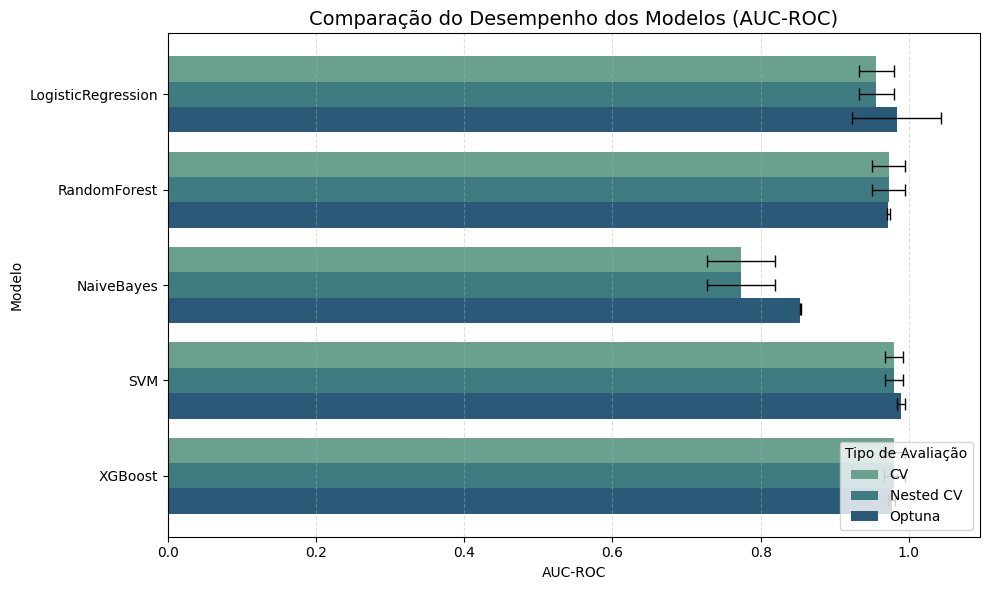

In [ ]:
df_list = []
for model in results_optuna.index:
    if model != 'Baseline_Dummy':
        
        df_list.append({'Modelo': model, 'Tipo': 'CV', 'AUC': results_raw.loc[model, 'Média'], 
                        'Desvio': results_raw.loc[model, 'Desvio Padrão']})
        df_list.append({'Modelo': model, 'Tipo': 'Nested CV', 'AUC': results_cv.loc[model, 'Média'], 
                        'Desvio': results_cv.loc[model, 'Desvio Padrão']})
        df_list.append({'Modelo': model, 'Tipo': 'Optuna', 'AUC': results_optuna.loc[model, 'Média'], 
                        'Desvio': results_optuna.loc[model, 'Desvio Padrão']})

df_long = pd.DataFrame(df_list)

# Ordem das barras
tipo_ordem = ['CV', 'Nested CV', 'Optuna']

# Configuração do gráfico
plt.figure(figsize=(10,6))
palette_colors = sns.color_palette("crest", n_colors=3)  # paleta harmônica

# Criando gráfico de barras agrupadas
bar_plot = sns.barplot(
    x='AUC',
    y='Modelo',
    hue='Tipo',
    data=df_long,
    hue_order=tipo_ordem,
    palette=palette_colors,
    ci=None
)

# Adicionando barras de erro bem alinhadas
bar_width = 0.25  # largura relativa de cada barra
for i, model in enumerate(df_long['Modelo'].unique()):
    for j, tipo in enumerate(tipo_ordem):
        auc = df_long[(df_long['Modelo']==model) & (df_long['Tipo']==tipo)]['AUC'].values[0]
        err = df_long[(df_long['Modelo']==model) & (df_long['Tipo']==tipo)]['Desvio'].values[0]
        # posição horizontal das barras: -bar_width, 0, +bar_width
        y_pos = i - bar_width + j*bar_width
        plt.errorbar(
            x=auc,
            y=y_pos,
            xerr=err,
            fmt='none',
            ecolor='black',
            capsize=4,
            lw=1
        )

# Ajustes finais
plt.title('Comparação do Desempenho dos Modelos (AUC-ROC)', fontsize=14)
plt.xlabel('AUC-ROC')
plt.ylabel('Modelo')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.legend(title='Tipo de Avaliação', loc='lower right')
plt.tight_layout()
plt.show()

A análise do gráfico de AUC-ROC complementa as avaliações anteriores, mostrando que XGBoost e SVM se destacam como os modelos de maior capacidade discriminativa, com AUC médio acima de 0,97 em todas as abordagens (CV, Nested CV e Optuna). A convergência dos resultados entre os diferentes tipos de validação reforça a robustez e estabilidade desses algoritmos, indicando que o ajuste de hiperparâmetros via Optuna não trouxe ganhos expressivos, mas consolidou a confiabilidade dos desempenhos já observados.
 
O Random Forest também manteve resultados sólidos (AUC ≈ 0,97) com variações mínimas, evidenciando previsões consistentes. A Regressão Logística, embora ligeiramente inferior (AUC ≈ 0,93–0,97), ainda apresentou desempenho competitivo, com barras de erro um pouco maiores que indicam maior sensibilidade à partição dos dados. Já o Naive Bayes continua na faixa mais baixa de desempenho (AUC ≈ 0,77–0,78), confirmando sua limitação em capturar relações mais complexas entre as variáveis.
 
De modo geral, o gráfico demonstra que os modelos de maior complexidade — especialmente XGBoost e SVM — mantêm alta precisão e generalização, consolidando-se como as abordagens mais adequadas para o conjunto de dados analisado.

__5. Matriz de confusão dos resultados__

Segue a matriz de confusão dos resultados obtidos com os hiperparâmetros selecionados pelo optuna:


Matriz de Confusão — LogisticRegression
[[11  0]
 [ 0 50]]


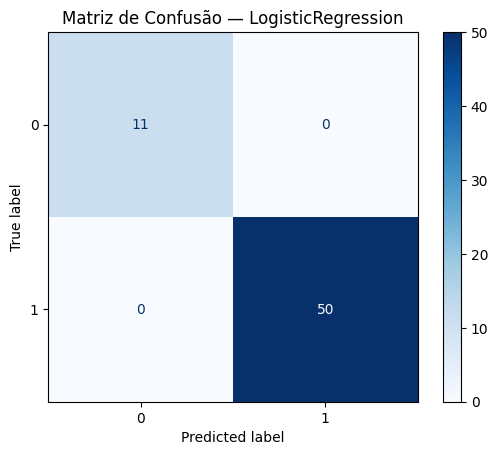


Matriz de Confusão — RandomForest
[[11  0]
 [ 0 50]]


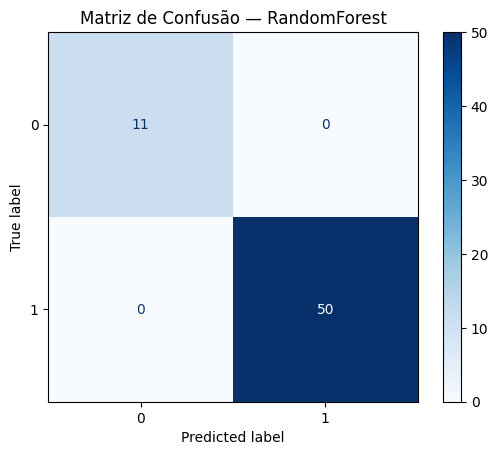


Matriz de Confusão — NaiveBayes
[[11  0]
 [ 8 42]]


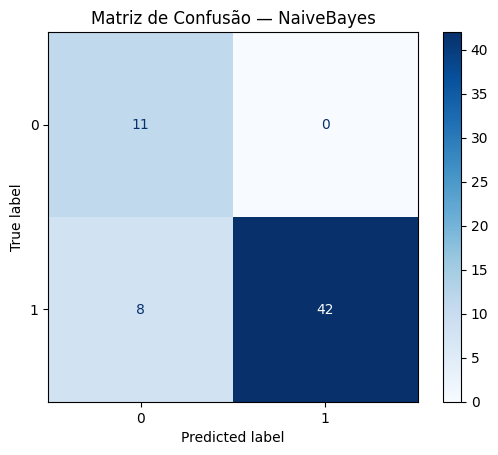


Matriz de Confusão — SVM
[[11  0]
 [ 0 50]]


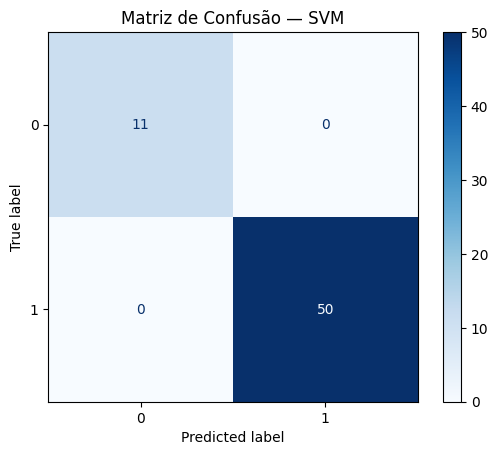


Matriz de Confusão — XGBoost
[[11  0]
 [ 0 50]]


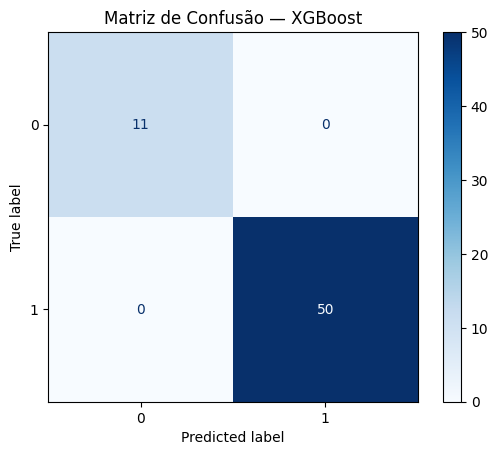

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Criar matriz de confusão para cada modelo treinado
for name, model in final_models.items():
    print(f"\nMatriz de Confusão — {name}")

    # prever classe
    y_pred = model.predict(X_test)
    
    # calcular matriz
    cm = confusion_matrix(y_test, y_pred)
    
    # printar valores
    print(cm)
    
    # plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Matriz de Confusão — {name}")
    plt.show()

Podemos observar que Floresta Aleatória, SVM, Regressão Logística e XGBoost acertaram todos os diagnósticos. Apenas Naive Bayes cometeu 8 falsos negativos (erro tipo II). Isso indica que os modelos tiveram excelentes resultados. 

### 3. Explicação de modelos

O Permutation Importance é uma das ferramentas para explicação de modelos. Ele retorna como resultado quais atributos são mais importantes para o seu modelo, ou seja, quais atributos são mais relevantes na hora de realizar a previsão. Para rodar essa ferramenta em um modelo é necessário que o modelo esteja pronto e que suas métricas de acertabilidade estejam calculadas. A seguir, o procedimento ocorre da seguinte forma: cada um dos atributos é permutado aleatoriamente nos dados de teste. O modelo fará novas previsões com esses dados de teste "bagunçados" em uma variável. Essas previsões irão gerar novos valores para as métricas. Então, serão calculadas as diferenças entre os valores das métricas com o modelo não "bagunçado" e com o modelo "bagunçado", para cada atributo:

\begin{equation}
Imp_v = AUCROC_{nb} - AUCROC_{b}
\end{equation}

Quanto maior $Imp_v$, maior a importância da variável. No caso, como AUC-ROC vai de 0 a 1, os nossos valores para Imp_v também irão de 0 a 1. 

No caso, para aplicarmos essa ferramenta iremos fazer da seguinte forma:

A ferramenta irá calcular os valores de todas as importâncias para todas as 1922 variáveis do dataset, para os 5 modelos. Para cada variável esse cálculo será realizado 5 vezes, para garantir estabilidade dos resultados. Esses resultados serão armazenados em arquivos .csv gerados pelo próprio código. A seguir, o código irá gerar outros arquivos .csv com as 100 variáveis mais importantes para cada modelo, em ordem decrescente. Nesses datasets, `importance_mean` configura a importância média daquela variável, calculada a partir de (1), `n_repeats` vezes, quando ela é embaralhada. `importance_std` se refere ao desvio padrão da importância média da variável. 

Os maiores 10 valores de importância são mostrados depois do código para cada modelo. 

In [ ]:
from sklearn.inspection import permutation_importance
import pandas as pd
import os

# Criar pasta para salvar resultados
os.makedirs("permutation_results", exist_ok=True)

results_perm = {}
top100_perm = {}

for name, model in final_models.items():
    print(f"\nCalculando permutation importance para: {name}")
    
    r = permutation_importance(
        model,
        X_test,
        y_test,
        n_repeats=5,
        scoring="roc_auc",
        random_state=42,
        n_jobs=-1
    )
    
    # DataFrame completo
    df_PI = pd.DataFrame({
        "feature": X_test.columns,
        f"{name}_importance_mean": r.importances_mean,
        f"{name}_importance_std": r.importances_std
    }).sort_values(by=f"{name}_importance_mean", ascending=False)

    results_perm[name] = df_PI
    
    # Salvar resultado completo
    df_PI.to_csv(f"permutation_results/permutation_importance_{name}.csv", index=False)
    
    # Selecionar top-100 features
    df_top100 = df_PI.head(100).reset_index(drop=True)
    top100_perm[name] = df_top100
    
    # Salvar top-100 em arquivo
    df_top100.to_csv(f"permutation_results/top100_features_{name}.csv", index=False)

    print(f"✅ Top-100 salvo para {name}")
    print(df_top100.head(10))


Calculando permutation importance para: LogisticRegression
✅ Top-100 salvo para LogisticRegression
               feature  LogisticRegression_importance_mean  \
0  Patient_Sex_Encoded                                 0.0   
1      ENSG00000000005                                 0.0   
2      ENSG00000280411                                 0.0   
3      ENSG00000280362                                 0.0   
4      ENSG00000280228                                 0.0   
5      ENSG00000280223                                 0.0   
6      ENSG00000280219                                 0.0   
7      ENSG00000280165                                 0.0   
8      ENSG00000280114                                 0.0   
9      ENSG00000280079                                 0.0   

   LogisticRegression_importance_std  
0                                0.0  
1                                0.0  
2                                0.0  
3                                0.0  
4                     

##### 3.1 Interpretação dos resultados

Podemos observar, que, de forma à primeira vista estranha, os valores ficaram todos em 0 para Regressão Logística, Floresta Aleatória, SVM e XGBoost. Apenas o Naive Bayes obteve algumas features diferentes com importâncias diferentes de 0. Mas há uma importante explicação que podem haver para esse fato:

Nosso dataset continha 1922 atributos, e os modelos com valores 0 de importância para todos os atributos, obtiveram valores de AUC ROC muito próximos de 1. Os resultados do Permutation importance permitem levantar a hipótese de que o cálculo de (1) dá 0 pois para um modelo muito bom, variar apenas uma das 1922 variáveis por vez, não diminui a AUC ROC do modelo. Essa é uma teoria que faz sentido, pelo grande número de variáveis. Apenas no Naive Bayes é possível observar que há variáveis com valores de importância diferentes de 0, o que pode ser atribuído ao fato de que ele tem a menor AUC ROC dentre os modelos testados, e por isso fica mais sensível à alterações em uma das features. 

## Conclusão

As avaliações de performance demonstraram que a maioria dos modelos atingiu resultados notavelmente altos, com valores de acurácia e AUC-ROC próximos do ótimo e baixos desvios padrão, evidenciando consistência e estabilidade entre as diferentes metodologias de validação (CV, Nested CV e Optuna). Entre os preditores, XGBoost e SVM se consolidaram como os modelos de melhor desempenho global, apresentando tanto alta capacidade discriminativa quanto robustez frente à variação dos dados. O Random Forest e a Regressão Logística também mantiveram desempenhos competitivos, enquanto o Naive Bayes apresentou resultados sistematicamente inferiores, embora estáveis.
 
A convergência entre os valores obtidos nas diferentes etapas — especialmente entre a validação cruzada e os resultados otimizados via Optuna — indica que os modelos já operavam próximos de seu limite de desempenho, sugerindo que o ajuste de hiperparâmetros trouxe refinamentos mínimos, mas reforçou a reprodutibilidade e a confiabilidade das métricas.
 
Contudo, o nível de excelência alcançado levanta uma reflexão importante: esses resultados podem indicar que os modelos estão, de fato, capturando de forma precisa a estrutura intrínseca dos dados, ou que as features disponíveis são altamente descritivas, tornando a tarefa de classificação menos desafiadora. Com o intuito de distinguir essas possibilidades e compreender como os algoritmos tomam suas decisões, foi realizada uma análise de interpretabilidade com a técnica Permutation importance, que visa dar um valor para a importância de cada atributo. Entretanto, essa análise não ocorreu como desejado, devida à grande quantidade de atributos e alta qualidade dos modelos. 

## Referências

1. EUROPEAN BIOINFORMATICS INSTITUTE. E-GEOD-101794 — Downloads. Disponível em: https://www.ebi.ac.uk/gxa/experiments/E-GEOD-101794/Downloads
.

2. ASSIS, Janilson Pinheiro de; SOUSA, Roberto Pequeno de; LINHARES, Paulo César Ferreira. Testes de Hipóteses Estatísticas. Mossoró, RN: EdUFERSA, 2020.

3. LOVE, Michael I.; HUBER, Wolfgang; ANDERS, Simon. Moderated estimation of fold change and dispersion for RNA-seq data with DESeq2. Genome Biology, v. 15, n. 12, p. 550, 2014.

4. GOOGLE. Gemini. Disponível em: https://gemini.google.com/app
.

5. SCIKIT-LEARN. StratifiedKFold — scikit-learn 1.3.2 documentation. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
.

6. SCIKIT-LEARN. cross_val_score — scikit-learn 1.3.2 documentation. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
.

7. SCIKIT-LEARN. LogisticRegression — scikit-learn 1.3.2 documentation. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
.

8. SCIKIT-LEARN. RandomForestClassifier — scikit-learn 1.3.2 documentation. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
.

9. SCIKIT-LEARN. SVC — scikit-learn 1.3.2 documentation. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
.

10. SCIKIT-LEARN. GaussianNB — scikit-learn 1.3.2 documentation. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
.

11. XGBOOST. XGBClassifier — XGBoost documentation. Disponível em: https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier
.

12. SCIKIT-LEARN. roc_auc_score — scikit-learn 1.3.2 documentation. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
.

13. OPTUNA. Optuna: A hyperparameter optimization framework. Disponível em: https://optuna.org/
.

14. SEABORN. barplot — Seaborn documentation. Disponível em: https://seaborn.pydata.org/generated/seaborn.barplot.html
.

15. MATPLOTLIB. pyplot.bar — Matplotlib documentation. Disponível em: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html
.

16. HARVARD UNIVERSITY. CS50 — Introduction to Computer Science. Disponível em: https://cs50.harvard.edu/x/
.

17. OPENAI. ChatGPT. Disponível em: https://chat.openai.com/
.

_Observações:_ A IA foi utilizada como auxilio na identificação das etapas para o tratamento de dados e na elaboração dos códigos para realizar o tratamento, em especial para as formatações exibidas no console, no entendimento e no auxílio dos códigos dos modelos e hiperparâmetros, além de ser utilizado para a plotagem dos gráficos e auxiliar na interpretação dos resultados obtidos.

